In [1]:
library(phyloseq, verbose=FALSE)
library(corncob, verbose=FALSE)
library(magrittr, verbose=FALSE)
library(ggplot2, verbose=FALSE)

Warning message:
“package ‘magrittr’ was built under R version 4.1.3”


In [2]:
load("../02-diversity/master_phyloseq.RData")
ps.dat
# head(sample_data(ps.dat))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

## 1. HUU kids

In [3]:
# head(tax_table(ps.dat))
# TO DO: ONLY LOOK AT ADULT H-CF SAMPLES?
ps.dat.glom <- ps.dat %>%
                phyloseq::subset_samples(hiv_status == "HUU") %>%
                tax_glom("V8")
ps.dat.glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 628 taxa and 614 samples ]
sample_data() Sample Data:       [ 614 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 628 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 628 tips and 627 internal nodes ]

In [4]:
# differential abundance analysis 
set.seed(234)
da_analysis <- differentialTest(formula = ~ visit_num,
                               phi.formula = ~ visit_num,
                               formula_null = ~ 1,
                               phi.formula_null = ~ visit_num,
                               test = "Wald",
                               boot = FALSE,
                               data = ps.dat.glom,
                               fdr_cutoff = 0.05)
da_analysis

Object of class differentialTest 

$p: p-values 
$p_fdr: FDR-adjusted p-values 
$significant_taxa: taxa names of the statistically significant taxa 
$significant_models: model summaries of the statistically significant taxa 
$all_models: all model summaries 
$restrictions_DA: covariates tested for differential abundance 
$restrictions_DV: covariates tested for differential variability 
$discriminant_taxa_DA: taxa for which at least one covariate associated with the abundance was perfectly discriminant 
$discriminant_taxa_DV: taxa for which at least one covariate associated with the dispersion was perfectly discriminant 

plot( ) to see a plot of tested coefficients from significant taxa 

In [5]:
# plot results (modified from plot.differentialTest function in corncob)
# modified from plot_differentialTest.R in corncob
level <- c("V8")
x <- da_analysis

signif_taxa <- otu_to_taxonomy(x$significant_taxa, x$data, level = level)
signif_taxa <- gsub("_", " ", signif_taxa) # NOTE: ASV label no longer informative after glom
signif_taxa
var_per_mod <- length(x$restrictions_DA) + length(x$restrictions_DV)
total_var_count <- length(signif_taxa) * var_per_mod
# initialize empty dataframe
df <- as.data.frame(matrix(NA, nrow = total_var_count, ncol = 5))
colnames(df) <- c("x", "xmin", "xmax", "taxa", "variable")

qval <- stats::qnorm(.975)
restricts_mu <- attr(x$restrictions_DA, "index")
restricts_phi <- attr(x$restrictions_DV, "index")

# loop through models to populate dataframe
count <- 1
for (i in 1:length(x$significant_models)) {
  # Below from print_summary_bbdml, just to get coefficient names
  tmp <- x$significant_models[[i]]
  coefs.mu <- tmp$coefficients[1:tmp$np.mu,, drop = FALSE]
  rownames(coefs.mu) <- paste0(substring(rownames(coefs.mu), 4), " Differential Abundance")
  coefs.mu <- coefs.mu[restricts_mu,, drop = FALSE]

  coefs.phi <- tmp$coefficients[(tmp$np.mu + 1):nrow(tmp$coefficients),, drop = FALSE]
  rownames(coefs.phi) <- paste0(substring(rownames(coefs.phi), 5), " Differential Variability")
  coefs.phi <- coefs.phi[restricts_phi - tmp$np.mu,, drop = FALSE]

  coefs <- rbind(coefs.mu, coefs.phi)
  for (j in 1:var_per_mod) {
    df[count, 1:3] <- c(coefs[j, 1], coefs[j, 1] - qval * coefs[j, 2],
                      coefs[j, 1] + qval * coefs[j, 2])
    df[count, 4:5] <- c(signif_taxa[i], rownames(coefs)[j])
    count <- count + 1
    }
}

head(df)

ASV6627 
                                "Butyricimonas virosa" 
                                                ASV950 
                            "Capnocytophaga granulosa" 
                                                ASV361 
"Candidatus Saccharibacteria bacterium oral taxon 957" 
                                                ASV245 
                         "Peptostreptococcus stomatis" 
                                               ASV1591 
                               "Abiotrophia defectiva" 
                                                ASV454 
                             "Streptococcus cristatus" 
                                                 ASV54 
                             "Streptococcus sanguinis" 
                                                 ASV56 
                                 "Arachnia propionica" 
                                               ASV5208 
                            "unclassified Actinomyces" 
                                                ASV663 
                               "Corynebacterium durum" 
                                                 ASV89 
                       "Eubacterium brachy ATCC 33089" 
                                                ASV570 
                              "Mogibacterium diversum"

,x,xmin,xmax,taxa,variable
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,-4.6732371,-7.1067035,-2.2397707,Butyricimonas virosa,visit_num2 Differential Abundance
2,-0.8868735,-3.6873537,1.9136068,Butyricimonas virosa,visit_num3 Differential Abundance
3,0.5442247,0.1954015,0.8930479,Capnocytophaga granulosa,visit_num2 Differential Abundance
4,0.6212024,0.2670529,0.9753520,Capnocytophaga granulosa,visit_num3 Differential Abundance
5,2.5127315,1.4469041,3.5785590,Candidatus Saccharibacteria bacterium oral taxon 957,visit_num2 Differential Abundance
6,1.6226619,0.5952095,2.6501143,Candidatus Saccharibacteria bacterium oral taxon 957,visit_num3 Differential Abundance


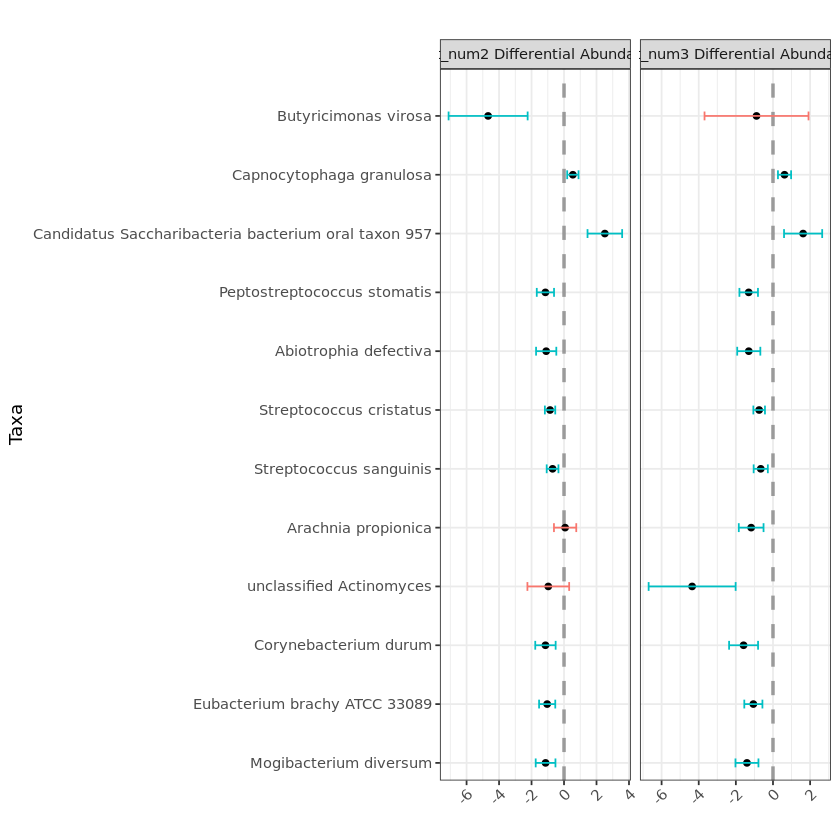

In [6]:
ggplot(df, aes(x = x, y = taxa)) +
  geom_vline(xintercept = 0, color = "gray50", lty = "dashed",
                          alpha = 0.75, lwd = 1) +
  geom_point() +
  geom_errorbarh(aes(xmin = xmin, xmax = xmax, colour = xmin<=0 & xmax <= 0| xmin>=0 & xmax >= 0), height = .3) +
  theme_bw() +
  facet_wrap(~variable, scales = "free_x", nrow = 1) +
  labs(title = "", x = "", y = "Taxa") +
  scale_y_discrete(limits = rev(df$taxa)) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position="none") # turned off legend

Differentially abundant taxa in HUU kids in visit one versus visit two and three

## 2. HI kids

In [7]:
# head(tax_table(ps.dat))
ps.dat.glom <- ps.dat %>%
                phyloseq::subset_samples(hiv_status == "HI") %>%
                tax_glom("V8")
ps.dat.glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 628 taxa and 735 samples ]
sample_data() Sample Data:       [ 735 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 628 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 628 tips and 627 internal nodes ]

In [8]:
# differential abundance analysis 
set.seed(234)
da_analysis <- differentialTest(formula = ~ visit_num,
                               phi.formula = ~ visit_num,
                               formula_null = ~ 1,
                               phi.formula_null = ~ visit_num,
                               test = "Wald",
                               boot = FALSE,
                               data = ps.dat.glom,
                               fdr_cutoff = 0.05)

In [9]:
level <- c("V8")
x <- da_analysis

signif_taxa <- otu_to_taxonomy(x$significant_taxa, x$data, level = level)
signif_taxa <- gsub("_", " ", signif_taxa) # NOTE: ASV label no longer informative after glom
signif_taxa
var_per_mod <- length(x$restrictions_DA) + length(x$restrictions_DV)
total_var_count <- length(signif_taxa) * var_per_mod
# initialize empty dataframe
df <- as.data.frame(matrix(NA, nrow = total_var_count, ncol = 5))
colnames(df) <- c("x", "xmin", "xmax", "taxa", "variable")

qval <- stats::qnorm(.975)
restricts_mu <- attr(x$restrictions_DA, "index")
restricts_phi <- attr(x$restrictions_DV, "index")

# loop through models to populate dataframe
count <- 1
for (i in 1:length(x$significant_models)) {
  # Below from print_summary_bbdml, just to get coefficient names
  tmp <- x$significant_models[[i]]
  coefs.mu <- tmp$coefficients[1:tmp$np.mu,, drop = FALSE]
  rownames(coefs.mu) <- paste0(substring(rownames(coefs.mu), 4), " Differential Abundance")
  coefs.mu <- coefs.mu[restricts_mu,, drop = FALSE]

  coefs.phi <- tmp$coefficients[(tmp$np.mu + 1):nrow(tmp$coefficients),, drop = FALSE]
  rownames(coefs.phi) <- paste0(substring(rownames(coefs.phi), 5), " Differential Variability")
  coefs.phi <- coefs.phi[restricts_phi - tmp$np.mu,, drop = FALSE]

  coefs <- rbind(coefs.mu, coefs.phi)
  for (j in 1:var_per_mod) {
    df[count, 1:3] <- c(coefs[j, 1], coefs[j, 1] - qval * coefs[j, 2],
                      coefs[j, 1] + qval * coefs[j, 2])
    df[count, 4:5] <- c(signif_taxa[i], rownames(coefs)[j])
    count <- count + 1
    }
}

head(df)

ASV562                           ASV245 
      "Capnocytophaga granulosa"    "Peptostreptococcus stomatis" 
                         ASV1852                           ASV310 
         "Abiotrophia defectiva"        "Streptococcus cristatus" 
                           ASV54                           ASV133 
       "Streptococcus sanguinis"        "Granulicatella adiacens" 
                          ASV109                            ASV22 
           "Gemella morbillorum"       "Gemella haemolysans M341" 
                          ASV116                          ASV3578 
                   "Clostridium"          "Schaalia odontolytica" 
                           ASV73                             ASV5 
   "Corynebacterium matruchotii"            "Rothia dentocariosa" 
                         ASV1445                          ASV1899 
             "Dialister invisus"       "unclassified Selenomonas" 
                           ASV89                           ASV570 
 "Eubacterium brachy ATCC 33089"         "Mogibacterium diversum" 
                         ASV4470                            ASV59 
         "Mogibacterium pumilum"  "Lachnoanaerobaculum saburreum" 
                          ASV942                           ASV150 
          "Treponema socranskii"         "Campylobacter gracilis" 
                          ASV353                           ASV167 
               "Neisseria sicca" "Aggregatibacter sp. 2125159857" 
                         ASV1179                           ASV957 
            "Moraxella cuniculi"      "Prevotella saccharolytica"

,x,xmin,xmax,taxa,variable
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.5814065,0.26773708,0.89507599,Capnocytophaga granulosa,visit_num2 Differential Abundance
2,0.2821229,-0.03370119,0.59794691,Capnocytophaga granulosa,visit_num3 Differential Abundance
3,-1.1292696,-1.60360551,-0.65493360,Peptostreptococcus stomatis,visit_num2 Differential Abundance
4,-1.2292986,-1.70131285,-0.75728431,Peptostreptococcus stomatis,visit_num3 Differential Abundance
5,-0.6052108,-1.14479583,-0.06562585,Abiotrophia defectiva,visit_num2 Differential Abundance
6,-1.2291564,-1.80265767,-0.65565504,Abiotrophia defectiva,visit_num3 Differential Abundance


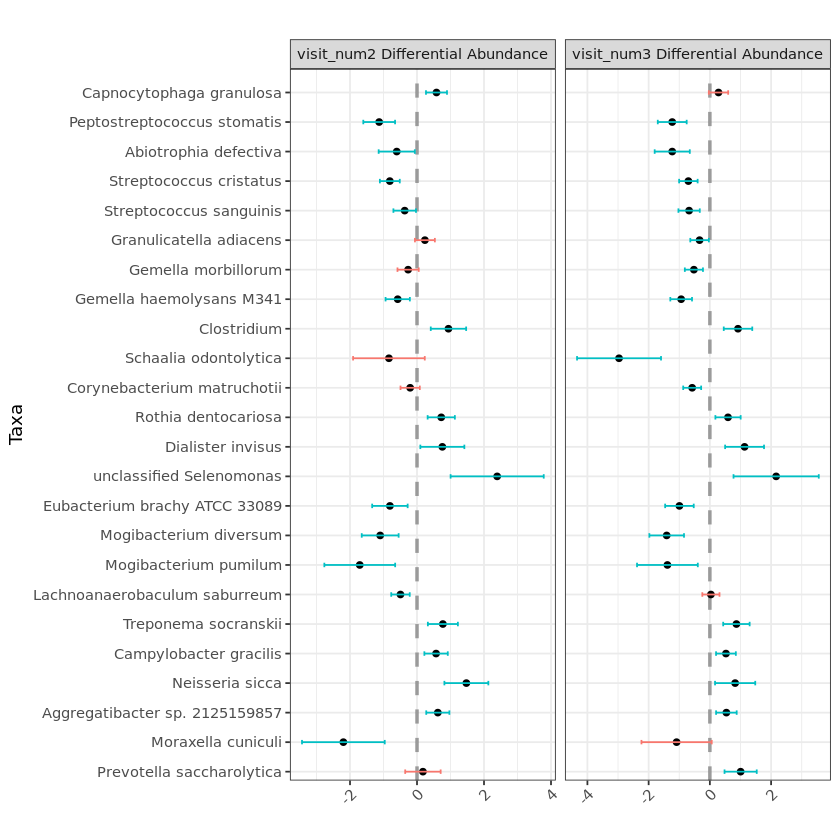

In [10]:
ggplot(df, aes(x = x, y = taxa)) +
  geom_vline(xintercept = 0, color = "gray50", lty = "dashed",
                          alpha = 0.75, lwd = 1) +
  geom_point() +
  geom_errorbarh(aes(xmin = xmin, xmax = xmax, colour = xmin<=0 & xmax <= 0| xmin>=0 & xmax >= 0), height = .3) +
  theme_bw() +
  facet_wrap(~variable, scales = "free_x", nrow = 1) +
  labs(title = "", x = "", y = "Taxa") +
  scale_y_discrete(limits = rev(df$taxa)) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position="none") # turned off legend

## 3. HEU kids

In [11]:
# head(tax_table(ps.dat))
ps.dat.glom <- ps.dat %>%
                phyloseq::subset_samples(hiv_status == "HEU") %>%
                tax_glom("V8")
ps.dat.glom
# differential abundance analysis 
set.seed(234)
da_analysis <- differentialTest(formula = ~ visit_num,
                               phi.formula = ~ visit_num,
                               formula_null = ~ 1,
                               phi.formula_null = ~ visit_num,
                               test = "Wald",
                               boot = FALSE,
                               data = ps.dat.glom,
                               fdr_cutoff = 0.05)
level <- c("V8")
x <- da_analysis

signif_taxa <- otu_to_taxonomy(x$significant_taxa, x$data, level = level)
signif_taxa <- gsub("_", " ", signif_taxa) # NOTE: ASV label no longer informative after glom
signif_taxa
var_per_mod <- length(x$restrictions_DA) + length(x$restrictions_DV)
total_var_count <- length(signif_taxa) * var_per_mod
# initialize empty dataframe
df <- as.data.frame(matrix(NA, nrow = total_var_count, ncol = 5))
colnames(df) <- c("x", "xmin", "xmax", "taxa", "variable")

qval <- stats::qnorm(.975)
restricts_mu <- attr(x$restrictions_DA, "index")
restricts_phi <- attr(x$restrictions_DV, "index")

# loop through models to populate dataframe
count <- 1
for (i in 1:length(x$significant_models)) {
  # Below from print_summary_bbdml, just to get coefficient names
  tmp <- x$significant_models[[i]]
  coefs.mu <- tmp$coefficients[1:tmp$np.mu,, drop = FALSE]
  rownames(coefs.mu) <- paste0(substring(rownames(coefs.mu), 4), " Differential Abundance")
  coefs.mu <- coefs.mu[restricts_mu,, drop = FALSE]

  coefs.phi <- tmp$coefficients[(tmp$np.mu + 1):nrow(tmp$coefficients),, drop = FALSE]
  rownames(coefs.phi) <- paste0(substring(rownames(coefs.phi), 5), " Differential Variability")
  coefs.phi <- coefs.phi[restricts_phi - tmp$np.mu,, drop = FALSE]

  coefs <- rbind(coefs.mu, coefs.phi)
  for (j in 1:var_per_mod) {
    df[count, 1:3] <- c(coefs[j, 1], coefs[j, 1] - qval * coefs[j, 2],
                      coefs[j, 1] + qval * coefs[j, 2])
    df[count, 4:5] <- c(signif_taxa[i], rownames(coefs)[j])
    count <- count + 1
    }
}

head(df)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 628 taxa and 611 samples ]
sample_data() Sample Data:       [ 611 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 628 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 628 tips and 627 internal nodes ]

ASV732 
                            "Capnocytophaga granulosa" 
                                                ASV546 
                                       "Bacteroidetes" 
                                                ASV400 
"Candidatus Saccharibacteria bacterium oral taxon 488" 
                                                ASV245 
                         "Peptostreptococcus stomatis" 
                                                ASV298 
                             "Streptococcus cristatus" 
                                                 ASV54 
                             "Streptococcus sanguinis" 
                                                 ASV22 
                            "Gemella haemolysans M341" 
                                               ASV1346 
                                   "Selenomonas noxia" 
                                                 ASV89 
                       "Eubacterium brachy ATCC 33089" 
                                                ASV362 
                      "Eubacterium nodatum ATCC 33099" 
                                                ASV570 
                              "Mogibacterium diversum" 
                                                ASV150 
                              "Campylobacter gracilis" 
                                                ASV588 
                    "Haemophilus paraphrohaemolyticus"

,x,xmin,xmax,taxa,variable
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.5779740,0.2464028,0.9095452,Capnocytophaga granulosa,visit_num2 Differential Abundance
2,0.5117191,0.1985887,0.8248495,Capnocytophaga granulosa,visit_num3 Differential Abundance
3,1.0762112,0.2653892,1.8870331,Bacteroidetes,visit_num2 Differential Abundance
4,1.6269588,0.8681698,2.3857478,Bacteroidetes,visit_num3 Differential Abundance
5,1.3234842,0.7238705,1.9230978,Candidatus Saccharibacteria bacterium oral taxon 488,visit_num2 Differential Abundance
6,1.5375328,0.9510787,2.1239869,Candidatus Saccharibacteria bacterium oral taxon 488,visit_num3 Differential Abundance


png 
  2

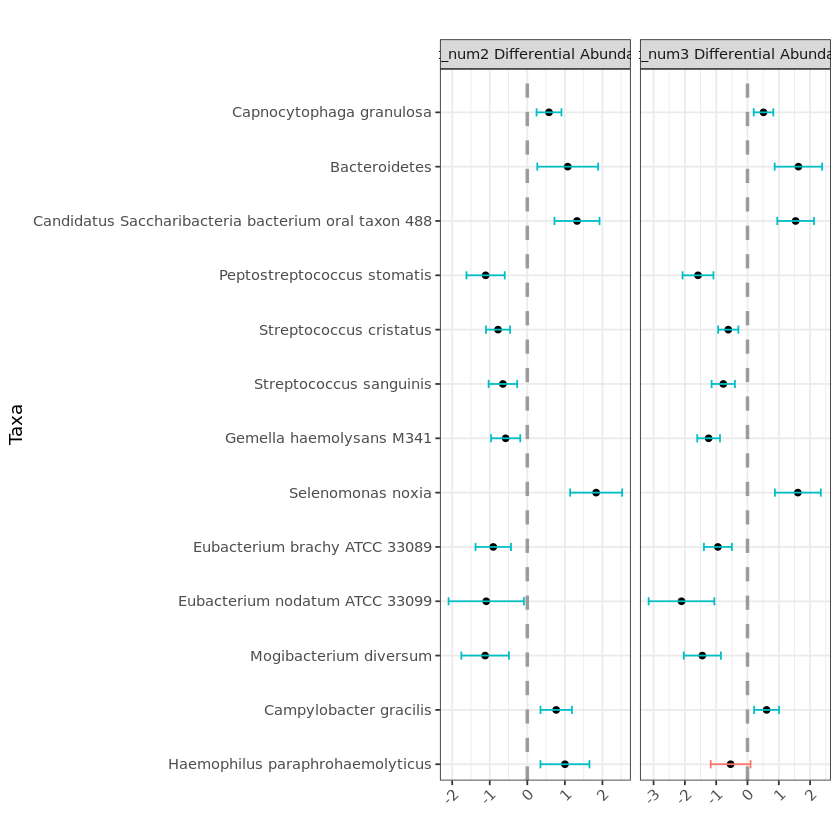

In [12]:
pdf("img/diffabund_vistnum.pdf")
ggplot(df, aes(x = x, y = taxa)) +
  geom_vline(xintercept = 0, color = "gray50", lty = "dashed",
                          alpha = 0.75, lwd = 1) +
  geom_point() +
  geom_errorbarh(aes(xmin = xmin, xmax = xmax, colour = xmin<=0 & xmax <= 0| xmin>=0 & xmax >= 0), height = .3) +
  theme_bw() +
  facet_wrap(~variable, scales = "free_x", nrow = 1) +
  labs(title = "", x = "", y = "Taxa") +
  scale_y_discrete(limits = rev(df$taxa)) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position="none") # turned off legend
dev.off()

ggplot(df, aes(x = x, y = taxa)) +
  geom_vline(xintercept = 0, color = "gray50", lty = "dashed",
                          alpha = 0.75, lwd = 1) +
  geom_point() +
  geom_errorbarh(aes(xmin = xmin, xmax = xmax, colour = xmin<=0 & xmax <= 0| xmin>=0 & xmax >= 0), height = .3) +
  theme_bw() +
  facet_wrap(~variable, scales = "free_x", nrow = 1) +
  labs(title = "", x = "", y = "Taxa") +
  scale_y_discrete(limits = rev(df$taxa)) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position="none") # turned off legend

## 4. HIV status + visit one vs visit three

In [13]:
# head(tax_table(ps.dat))
ps.dat.glom <- ps.dat %>%
                phyloseq::subset_samples(visit_num == "1" | visit_num == "3") %>%
                tax_glom("V8")
ps.dat.glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 628 taxa and 1364 samples ]
sample_data() Sample Data:       [ 1364 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 628 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 628 tips and 627 internal nodes ]

In [14]:
# set HUU as base level factor 
sample_data(ps.dat.glom)$hiv_status <- factor(sample_data(ps.dat.glom)$hiv_status, levels=c("HUU", "HEU", "HI"))
# sample_data(ps.dat.glom)$hiv_status
sample_data(ps.dat.glom)$visit_num <- factor(sample_data(ps.dat.glom)$visit_num, levels=c("1", "3"))
# sample_data(ps.dat.glom)$visit_num

In [15]:
# differential abundance analysis 
set.seed(234)
da_analysis <- differentialTest(formula = ~ hiv_status + visit_num,
                               phi.formula = ~ hiv_status + visit_num,
                               formula_null = ~ 1,
                               phi.formula_null = ~ hiv_status + visit_num,
                               test = "Wald",
                               boot = FALSE,
                               data = ps.dat.glom,
                               fdr_cutoff = 0.001)
level <- c("V8")
x <- da_analysis

signif_taxa <- otu_to_taxonomy(x$significant_taxa, x$data, level = level)
signif_taxa <- gsub("_", " ", signif_taxa) # NOTE: ASV label no longer informative after glom
signif_taxa
var_per_mod <- length(x$restrictions_DA) + length(x$restrictions_DV)
total_var_count <- length(signif_taxa) * var_per_mod
# initialize empty dataframe
df <- as.data.frame(matrix(NA, nrow = total_var_count, ncol = 5))
colnames(df) <- c("x", "xmin", "xmax", "taxa", "variable")

qval <- stats::qnorm(.975)
restricts_mu <- attr(x$restrictions_DA, "index")
restricts_phi <- attr(x$restrictions_DV, "index")

# loop through models to populate dataframe
count <- 1
for (i in 1:length(x$significant_models)) {
  # Below from print_summary_bbdml, just to get coefficient names
  tmp <- x$significant_models[[i]]
  coefs.mu <- tmp$coefficients[1:tmp$np.mu,, drop = FALSE]
  rownames(coefs.mu) <- paste0(substring(rownames(coefs.mu), 4), " Differential Abundance")
  coefs.mu <- coefs.mu[restricts_mu,, drop = FALSE]

  coefs.phi <- tmp$coefficients[(tmp$np.mu + 1):nrow(tmp$coefficients),, drop = FALSE]
  rownames(coefs.phi) <- paste0(substring(rownames(coefs.phi), 5), " Differential Variability")
  coefs.phi <- coefs.phi[restricts_phi - tmp$np.mu,, drop = FALSE]

  coefs <- rbind(coefs.mu, coefs.phi)
  for (j in 1:var_per_mod) {
    df[count, 1:3] <- c(coefs[j, 1], coefs[j, 1] - qval * coefs[j, 2],
                      coefs[j, 1] + qval * coefs[j, 2])
    df[count, 4:5] <- c(signif_taxa[i], rownames(coefs)[j])
    count <- count + 1
    }
}

head(df)

ASV901 
   "Bacteroidetes bacterium oral taxon 272 str. F0290" 
                                                ASV562 
                            "Capnocytophaga granulosa" 
                                                ASV546 
                                       "Bacteroidetes" 
                                                ASV400 
"Candidatus Saccharibacteria bacterium oral taxon 488" 
                                                ASV245 
                         "Peptostreptococcus stomatis" 
                                               ASV1591 
                               "Abiotrophia defectiva" 
                                                ASV298 
                             "Streptococcus cristatus" 
                                               ASV1160 
                                 "Streptococcus mitis" 
                                                 ASV54 
                             "Streptococcus sanguinis" 
                                               ASV6287 
                                "Streptococcus downei" 
                                                ASV109 
                                 "Gemella morbillorum" 
                                                 ASV22 
                            "Gemella haemolysans M341" 
                                               ASV2074 
                                    "Parvimonas micra" 
                                                ASV116 
                                         "Clostridium" 
                                                 ASV61 
                     "Leptotrichia sp. oral taxon 417" 
                                               ASV5643 
                      "Propionibacterium australiense" 
                                               ASV3578 
                               "Schaalia odontolytica" 
                                               ASV1817 
                            "Corynebacterium mustelae" 
                                                 ASV44 
                         "Corynebacterium matruchotii" 
                                                ASV663 
                               "Corynebacterium durum" 
                                                ASV985 
                                   "Dialister invisus" 
                                               ASV1477 
                                   "Selenomonas noxia" 
                                                 ASV89 
                       "Eubacterium brachy ATCC 33089" 
                                                ASV570 
                              "Mogibacterium diversum" 
                                                 ASV85 
                               "Enterocloster bolteae" 
                                                ASV167 
                      "Aggregatibacter sp. 2125159857" 
                                                ASV157 
                                          "Prevotella" 
                                               ASV2059 
                                   "Prevotella shahii" 
                                               ASV6582 
                                    "Prevotella bivia"

,x,xmin,xmax,taxa,variable
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,-0.8133880,-1.8540792,0.22730329,Bacteroidetes bacterium oral taxon 272 str. F0290,hiv_statusHEU Differential Abundance
2,1.2895275,0.4185057,2.16054934,Bacteroidetes bacterium oral taxon 272 str. F0290,hiv_statusHI Differential Abundance
3,0.6084097,-0.1524043,1.36922374,Bacteroidetes bacterium oral taxon 272 str. F0290,visit_num3 Differential Abundance
4,-0.1840191,-0.4202388,0.05220062,Capnocytophaga granulosa,hiv_statusHEU Differential Abundance
5,-0.1640443,-0.4019679,0.07387923,Capnocytophaga granulosa,hiv_statusHI Differential Abundance
6,0.4611758,0.2722471,0.65010450,Capnocytophaga granulosa,visit_num3 Differential Abundance


png 
  2

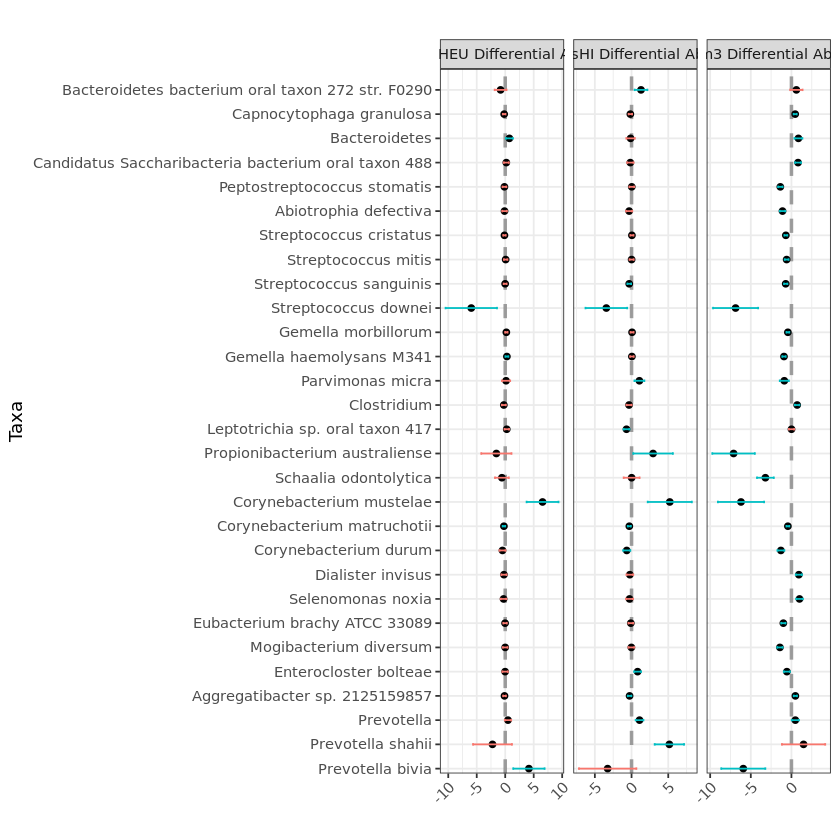

In [16]:
ggplot(df, aes(x = x, y = taxa)) +
  geom_vline(xintercept = 0, color = "gray50", lty = "dashed",
                          alpha = 0.75, lwd = 1) +
  geom_point() +
  geom_errorbarh(aes(xmin = xmin, xmax = xmax, colour = xmin<=0 & xmax <= 0| xmin>=0 & xmax >= 0), height = .3) +
  theme_bw() +
  facet_wrap(~variable, scales = "free_x", nrow = 1) +
  labs(title = "", x = "", y = "Taxa") +
  scale_y_discrete(limits = rev(df$taxa)) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position="none") # turned off legend
pdf("diff_abund_hivstatus_v1vsv3.pdf")
ggplot(df, aes(x = x, y = taxa)) +
  geom_vline(xintercept = 0, color = "gray50", lty = "dashed",
                          alpha = 0.75, lwd = 1) +
  geom_point() +
  geom_errorbarh(aes(xmin = xmin, xmax = xmax, colour = xmin<=0 & xmax <= 0| xmin>=0 & xmax >= 0), height = .3) +
  theme_bw() +
  facet_wrap(~variable, scales = "free_x", nrow = 1) +
  labs(title = "", x = "", y = "Taxa") +
  scale_y_discrete(limits = rev(df$taxa)) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position="none") # turned off legend
dev.off()